In [3]:
import pandas as pd
from pathlib import Path
from typing import Tuple
from itertools import product
from collections import defaultdict
import json
import numpy as np
from scipy import stats
from math import sqrt
from enum import Enum
from dataclasses import dataclass
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
# import upsetplot


plt.style.use("ggplot")
CONF = 0.95


In [9]:
def sample_name(s: str) -> str:
    for sfx in ["_rep1", "_rep2", "-singleplex", "-multiplex"]:
        s = s.replace(sfx, "")
    return s

def load_susceptibility(stream) -> dict:
    """Extract the susceptibility info from the JSON"""
    data = json.load(stream)
    try:
        return data[next(iter(data.keys()))]["susceptibility"]
    except (KeyError, TypeError):
        return data["susceptibility"]

In [8]:
# ont_df = pd.read_csv("../../docs/ont_samples.csv", index_col="sample")

In [5]:
# jsons = list(Path("../../results/").rglob("*mykrobe.json"))

In [21]:
data = []
for p in jsons:
    with open(p) as fp:
        results = load_susceptibility(fp)
    name = p.name.split(".")[0]
    if "_rep" in name:
        continue
    tech = p.parts[3]
    if tech == "nanopore":
        is_multi = not pd.isna(ont_df.at[name, "barcode_kit"])
        source = "sputum"
    else:
        is_multi = False
        source = p.parts[5]
    name = sample_name(name)
    for drug, pred in results.items():
        data.append((name, tech, source, is_multi, drug, pred))

In [22]:
df = pd.DataFrame(data, columns=["name", "technology", "source", "is_multiplex", "drug", "prediction"])

In [23]:
df["prediction"] = [d["predict"] for d in df["prediction"]]

In [24]:
df

,name,technology,source,is_multiplex,drug,prediction
0,P224,illumina,sputum,False,Ofloxacin,S
1,P224,illumina,sputum,False,Moxifloxacin,S
2,P224,illumina,sputum,False,Isoniazid,S
3,P224,illumina,sputum,False,Kanamycin,S
4,P224,illumina,sputum,False,Ethambutol,S
...,...,...,...,...,...,...
2338,P217,nanopore,sputum,False,Ciprofloxacin,S
2339,P217,nanopore,sputum,False,Pyrazinamide,S
2340,P217,nanopore,sputum,False,Rifampicin,R
2341,P217,nanopore,sputum,False,Amikacin,S


In [25]:
df.to_csv("../../results/dst_predictions.csv", index=False)

In [26]:
df = pd.read_csv("../../results/dst_predictions.csv")
df

,name,technology,source,is_multiplex,drug,prediction
0,P224,illumina,sputum,False,Ofloxacin,S
1,P224,illumina,sputum,False,Moxifloxacin,S
2,P224,illumina,sputum,False,Isoniazid,S
3,P224,illumina,sputum,False,Kanamycin,S
4,P224,illumina,sputum,False,Ethambutol,S
...,...,...,...,...,...,...
2338,P217,nanopore,sputum,False,Ciprofloxacin,S
2339,P217,nanopore,sputum,False,Pyrazinamide,S
2340,P217,nanopore,sputum,False,Rifampicin,R
2341,P217,nanopore,sputum,False,Amikacin,S


In [27]:
sputum_df = df.query("source=='sputum'")

In [28]:
culture_df = df.query("source=='culture'").set_index(["name", "drug"], verify_integrity=True)

https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html is a good place to get tips for doing this plot

and https://stackoverflow.com/questions/63530701/python-package-to-plot-two-heatmaps-in-one-split-each-square-into-two-triangles

In [41]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import product
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [34]:
set(df["drug"])

{'Amikacin',
 'Capreomycin',
 'Ciprofloxacin',
 'Ethambutol',
 'Isoniazid',
 'Kanamycin',
 'Moxifloxacin',
 'Ofloxacin',
 'Pyrazinamide',
 'Rifampicin',
 'Streptomycin'}

In [42]:
samples = set()
for s, _ in culture_df.index:
    samples.add(s)
    
drugs = ["Isoniazid", "Rifampicin", "Pyrazinamide", "Ethambutol", "Amikacin", "Streptomycin", "Amikacin", "Capreomycin", "Kanamycin", "Ciprofloxacin", "Moxifloxacin"]

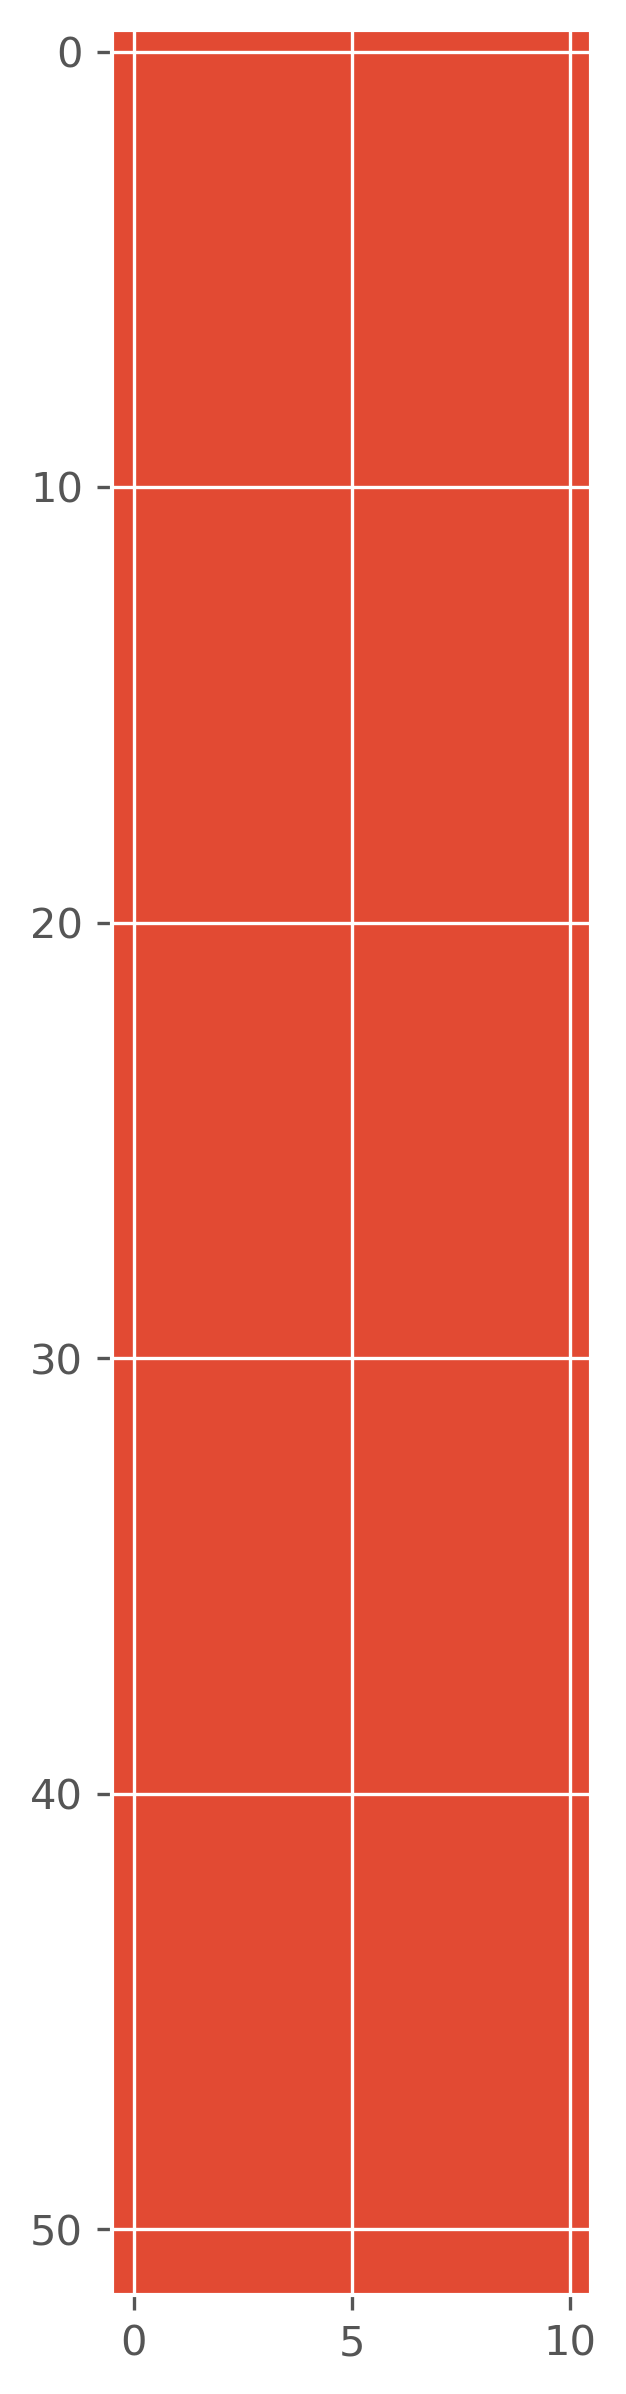

In [53]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

colors = [ggplot_cm[0], ggplot_cm[1]]
cmap = ListedColormap(colors)

ill_sputum = sputum_df.query("technology=='illumina'")


X = np.zeros((len(samples), len(drugs)))
for i, s in enumerate(samples):
    if s not in ill_sputum["name"]:
        continue
    for j, d in enumerate(drugs):
        expected = culture_df.at[(s, d), "prediction"]
        actual = ill_sputum.query("name==@s and drug==@d")["prediction"].iloc[0]
        X[i][j] = expected == actual
    

# plt.scatter(x, y, c=range(3), s=500, cmap=cmap, vmin=0, vmax=len(colors))
ax.imshow(X, cmap=cmap, vmin=0, vmax=len(colors))

In [50]:
sputum_df.query("name==@s and drug==@d and technology=='illumina'")["prediction"].iloc[0]

'S'